In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !conda install matplotlib
# !conda install numpy
# !conda install pandas
# !conda install scikit-learn
# !conda install tensorflow
# !pip install fasteda
# !conda install Jinja2 --y

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src import load_data, categorical_to_numerical, numerical_scaling, encode_label

In [4]:
# Settings
KAGGLE = False
CATEGORICAL_TO_NUMERICAL = True
ENCODE_LABEL = True
NUMERICAL_SCALING = True

numerical_features = [
    "N_Days",
    "Age",
    "Bilirubin",
    "Cholesterol",
    "Albumin",
    "Copper",
    "Alk_Phos",
    "SGOT",
    "Tryglicerides",
    "Platelets",
    "Prothrombin",
    "Stage",
]

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Edema", "Spiders"]

label_order = ["C", "CL", "D"]

#### Load Data

In [5]:
df_X_train, df_X_test, df_y_train, df_y_test = load_data(KAGGLE)

print(f"[X-train]: {df_X_train.shape}")
print(f"[y-train]: {df_y_train.shape}")
print(f"[X-test]: {df_X_test.shape}")
print(f"[y-test]: {df_y_test.shape}")

[X-train]: (7905, 18)
[y-train]: (7905,)
[X-test]: (5271, 18)
[y-test]: (5271, 4)


In [1]:
df_X_train

NameError: name 'df_X_train' is not defined

#### Data Scaling

In [6]:
if CATEGORICAL_TO_NUMERICAL:
    # train subset
    df_X_train = categorical_to_numerical(
        df_X_train, categorical_features, transformer="ordinal"
    ).copy(deep=True)

    # test subset
    df_X_test = categorical_to_numerical(
        df_X_test, categorical_features, transformer="ordinal"
    ).copy(deep=True)

if ENCODE_LABEL:
    # this ensures that the label order is the same one as in sample_submission
    encoded_label = encode_label(df_y_train.values, label_order)
    df_y_train = pd.DataFrame(encoded_label, columns=["Status"])


if NUMERICAL_SCALING:
    # train subset
    transformed_data, numerical_transformer = numerical_scaling(
        df_X_train[numerical_features].values, None
    )

    df_X_train = pd.concat(
        [
            pd.DataFrame(transformed_data, columns=numerical_features),
            df_X_train[df_X_train.columns.difference(numerical_features)],
        ],
        axis=1,
    )

    # test subset
    transformed_data, _ = numerical_scaling(
        df_X_test[numerical_features].values, numerical_transformer
    )

    df_X_test = pd.concat(
        [
            pd.DataFrame(transformed_data, columns=numerical_features),
            df_X_test[df_X_test.columns.difference(numerical_features)],
        ],
        axis=1,
    )

## **Split Data - Train + Validation**

In [7]:
from sklearn.model_selection import train_test_split

X = df_X_train.values
y = df_y_train["Status"].values

# Split into train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Test data
X_test = df_X_test.values

In [8]:
print(X.shape)
print(y.shape)

(7905, 18)
(7905,)


## **PCA**

In [9]:
from sklearn.decomposition import PCA

# Initialize PCA, you can choose the number of components
pca = PCA(n_components="mle")  # or use n_components='mle' to let PCA decide

# Fit PCA on the training data and transform it
X_train_pca = pca.fit_transform(X_train)

# Apply the mapping (transform) to the test data
X_test_pca = pca.transform(X_test)

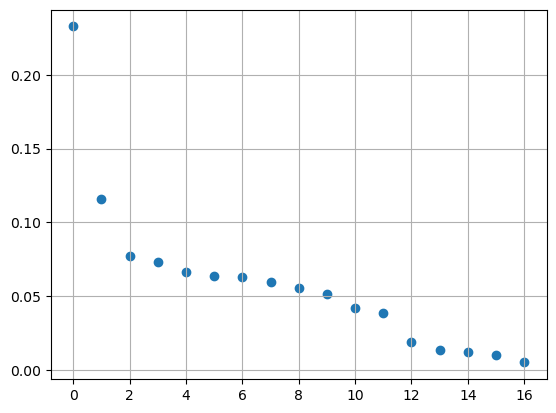

In [10]:
# Check how much VARIANCE each principal component accounts for in the data.
# This doesn't tell you how much each component explains the target,
# but it shows their importance in the feature space

n_pca_components = len(pca.explained_variance_ratio_)

plt.scatter(np.arange(n_pca_components), pca.explained_variance_ratio_)
plt.rc("axes", axisbelow=True)
plt.grid()

In [11]:
# Re-fit the PCA with the first 3 components
pca = PCA(n_components=2)  # or use n_components='mle' to let PCA decide

# Fit PCA on the training data and transform it
X_train_pca = pca.fit_transform(X_train)

# Apply the mapping (transform) to the validation data
X_validation_pca = pca.transform(X_validation)

# Apply the mapping (transform) to the test data
X_test_pca = pca.transform(X_test)

## **Model Initialization**

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

models = {}

# Naive Bayes (Gaussian Assumption)
models["naive_bayes"] = GaussianNB()

# Softmax Regression
models["softmax_regression"] = LogisticRegression(
    multi_class="multinomial", max_iter=10000, random_state=42
)

# SGD Classifier
models["sgd_classifier_ll"] = SGDClassifier(
    max_iter=10000, loss="log_loss", random_state=42
)

## **Model Validation**

In [13]:
from sklearn.metrics import log_loss, accuracy_score

decompositions = ["default", "pca"]

for model_name in models.keys():
    for decomposition in decompositions:
        if decomposition == "pca":
            fitted_model = models[model_name].fit(X_train_pca, y_train)
            y_validation_pred = models[model_name].predict(X_validation_pca)
            y_validation_pred_proba = models[model_name].predict_proba(X_validation_pca)
        elif decomposition == "default":
            fitted_model = models[model_name].fit(X_train, y_train)
            y_validation_pred = models[model_name].predict(X_validation)
            y_validation_pred_proba = models[model_name].predict_proba(X_validation)

        # Metrics computation
        acc = accuracy_score(y_validation, y_validation_pred) * 100
        ll = log_loss(y_validation, y_validation_pred_proba)

        print(f"{model_name.upper()} - {decomposition.upper()}\n------------------")
        print(
            f"[Validation Set] Mislabeled points : {(y_validation != y_validation_pred).sum()} out of {y_validation.shape[0]}"
        )

        print("[Validation Set] Accuracy: %.2f" % acc, "%")
        print("[Validation Set] Log-loss: %.2f" % ll)

        print("")

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


NAIVE_BAYES - DEFAULT
------------------
[Validation Set] Mislabeled points : 393 out of 1581
[Validation Set] Accuracy: 75.14 %
[Validation Set] Log-loss: 1.74

NAIVE_BAYES - PCA
------------------
[Validation Set] Mislabeled points : 344 out of 1581
[Validation Set] Accuracy: 78.24 %
[Validation Set] Log-loss: 0.60

SOFTMAX_REGRESSION - DEFAULT
------------------
[Validation Set] Mislabeled points : 326 out of 1581
[Validation Set] Accuracy: 79.38 %
[Validation Set] Log-loss: 0.53

SOFTMAX_REGRESSION - PCA
------------------
[Validation Set] Mislabeled points : 326 out of 1581
[Validation Set] Accuracy: 79.38 %
[Validation Set] Log-loss: 0.55

SGD_CLASSIFIER_LL - DEFAULT
------------------
[Validation Set] Mislabeled points : 342 out of 1581
[Validation Set] Accuracy: 78.37 %
[Validation Set] Log-loss: 0.55

SGD_CLASSIFIER_LL - PCA
------------------
[Validation Set] Mislabeled points : 330 out of 1581
[Validation Set] Accuracy: 79.13 %
[Validation Set] Log-loss: 0.55



## **Stratified k-Fold Cross-Validation**

In [14]:
from sklearn.model_selection import StratifiedKFold, KFold


def kfold_cross_validation(
    X: np.array,
    y: np.array,
    model: callable,
    n_splits: int,
    shuffle: bool,
    random_state: int = 42,
    type: str = "stratified",
) -> tuple[float, float]:
    # Initialize KFold
    if type == "stratified":
        kf = StratifiedKFold(
            n_splits=n_splits, shuffle=shuffle, random_state=random_state
        )
    elif type == "default":
        kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    accuracies = []
    log_losses = []

    # Split and train model
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit model
        model.fit(X_train, y_train)

        # pred label
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        log_losses.append(log_loss(y_test, y_pred_proba))

    avg_accuracy = np.mean(accuracies)
    avg_log_loss = np.mean(log_losses)

    return avg_accuracy, avg_log_loss

In [15]:
for model_name in models.keys():
    acc, ll = kfold_cross_validation(
        X, y, models[model_name], n_splits=5, shuffle=True
    )

    print(f"{model_name.upper()}\n------------------")
    print("Average Accuracy: %.2f" % (acc * 100), "%")
    print("Average Log-loss: %.2f" % ll, "\n")

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to

NAIVE_BAYES
------------------
Average Accuracy: 75.32 %
Average Log-loss: 1.70 

SOFTMAX_REGRESSION
------------------
Average Accuracy: 79.61 %
Average Log-loss: 0.53 

SGD_CLASSIFIER_LL
------------------
Average Accuracy: 79.61 %
Average Log-loss: 0.55 



## **Neural Network**

In [16]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Dense(25, "relu"),
        tf.keras.layers.Dense(10, "relu"),
        tf.keras.layers.Dense(3, "linear"),
    ],
    name="idk",
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(X_train, y_train, epochs=30)

Epoch 1/30


2024-05-11 13:21:25.875172: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


198/198 [==============================] - 0s 727us/step - loss: 0.7268
Epoch 2/30
198/198 [==============================] - 0s 475us/step - loss: 0.5415
Epoch 3/30
198/198 [==============================] - 0s 420us/step - loss: 0.5225
Epoch 4/30
198/198 [==============================] - 0s 425us/step - loss: 0.5122
Epoch 5/30
198/198 [==============================] - 0s 410us/step - loss: 0.5061
Epoch 6/30
198/198 [==============================] - 0s 468us/step - loss: 0.5011
Epoch 7/30
198/198 [==============================] - 0s 367us/step - loss: 0.4973
Epoch 8/30
198/198 [==============================] - 0s 428us/step - loss: 0.4934
Epoch 9/30
198/198 [==============================] - 0s 477us/step - loss: 0.4898
Epoch 10/30
198/198 [==============================] - 0s 437us/step - loss: 0.4871
Epoch 11/30
198/198 [==============================] - 0s 370us/step - loss: 0.4841
Epoch 12/30
198/198 [==============================] - 0s 373us/step - loss: 0.4813
Epoch 13/30


In [17]:
history.history

{'loss': [0.7267734408378601,
  0.541468620300293,
  0.5225496292114258,
  0.5122143030166626,
  0.5060863494873047,
  0.5011283755302429,
  0.49727094173431396,
  0.49342361092567444,
  0.4898380935192108,
  0.4871360659599304,
  0.4840754568576813,
  0.4813230037689209,
  0.4800608456134796,
  0.477925568819046,
  0.47490888833999634,
  0.4724576771259308,
  0.4708155393600464,
  0.4685112535953522,
  0.4667346179485321,
  0.46619340777397156,
  0.46514081954956055,
  0.46283450722694397,
  0.46165773272514343,
  0.4605272114276886,
  0.4585452079772949,
  0.457347571849823,
  0.4558948278427124,
  0.4543894827365875,
  0.453119158744812,
  0.4513351023197174]}

In [18]:
prediction = model.predict(X_validation)  # prediction

y_validation_pred = np.argmax(prediction, axis=1)
y_validation_pred_proba = tf.nn.softmax(prediction)

acc = accuracy_score(y_validation, y_validation_pred) * 100
ll = log_loss(y_validation, y_validation_pred_proba)

print("Neural Network with Softmax Regression on the output layer\n------------------")

print("[Validation Set] Accuracy: %.2f" % acc, "%")
print("[Validation Set] Log-loss: %.2f" % ll)

print("")

50/50 [==============================] - 0s 289us/step
Neural Network with Softmax Regression on the output layer
------------------
[Validation Set] Accuracy: 81.34 %
[Validation Set] Log-loss: 0.50



/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


## **Predict Test Sample**

In [19]:
# y_test_proba = models["log_reg"].predict_proba(X_test)

# Neural network
prediction = model.predict(X_test)
y_test_pred_proba = tf.nn.softmax(prediction)


# Prepare submission DataFrame
df_y_test_pred_proba = pd.DataFrame(
    y_test_pred_proba, columns=["Status_C", "Status_CL", "Status_D"]
)

df_y_test_pred_proba = pd.concat([df_y_test["id"], df_y_test_pred_proba], axis=1)

display(df_y_test_pred_proba.head())
display(df_y_test_pred_proba.tail())

165/165 [==============================] - 0s 526us/step


,id,Status_C,Status_CL,Status_D
0,7905,0.735585,0.013972,0.250443
1,7906,0.844558,0.054557,0.100885
2,7907,0.015127,0.011951,0.972923
3,7908,0.923202,0.004084,0.072714
4,7909,0.753900,0.006120,0.239980


,id,Status_C,Status_CL,Status_D
5266,13171,0.906087,0.029890,0.064024
5267,13172,0.987614,0.001104,0.011282
5268,13173,0.861906,0.026473,0.111621
5269,13174,0.983794,0.010371,0.005835
5270,13175,0.271603,0.009200,0.719198


## **Submission**

In [20]:
if KAGGLE:
    # Save submission to a CSV file
    df_y_test_pred_proba.to_csv("submission.csv", index=False)

**NEXT STEPS**

In [21]:
# Next steps


# Stratified k-fold Cross-Validation
# Neural Network w/ logistic regression imbeded


# Decision Tree
# Random Forest
# XGBBoost
# Catboost
# lightGBM